In [20]:
# Imports and configuration
%load_ext autoreload
%autoreload 2

from scipy.stats import loguniform, randint, uniform
import src.helpers.model_helpers as mh
from scipy.stats import randint, loguniform
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_sample_weight

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Load modeling dataset and the split indices
X_train, y_train, X_test, y_test = mh.load_model_dataset(fraction=0.02, index_suffix="_catboost")

Loading dataset from /Users/c1burns/Documents/UTD/BUAN 6341/project_repo/data/processed/hmda_2024_model_catboost.parquet


In [22]:
# CatBoost wants categorical dtypes
exclude_cols = ["combined_loan_to_value_ratio", "loan_term", "intro_rate_period", "prepayment_penalty_term", "loan_to_income_ratio", "loan_amount", "income", "property_value"]
cat_cols = [col for col in X_train.columns if col not in exclude_cols]

for c in cat_cols:
    X_train[c] = X_train[c].astype("category")
    X_test[c]  = X_test[c].astype("category")

# CatBoost doesn't like NaN
MISSING = "__MISSING__"
for c in cat_cols:
    X_train[c] = X_train[c].astype("string")
    X_test[c]  = X_test[c].astype("string")
    X_train[c] = X_train[c].fillna(MISSING)
    X_test[c]  = X_test[c].fillna(MISSING)

cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]

In [23]:
# Train model

# Base estimator
cat = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="F1",
    verbose=False,
    random_seed=42,
    thread_count=-1
)

# Param grid
param_grid = {
    "depth": randint(4, 10),
    "learning_rate": loguniform(1e-3, 3e-1),
    "l2_leaf_reg": loguniform(1e-2, 1e2),
    "bagging_temperature": uniform(0.0, 1.0),
    "border_count": randint(64, 255),
    "random_strength": uniform(0.0, 1.0),
    "min_data_in_leaf": randint(20, 500),
    "scale_pos_weight": loguniform(0.5, 10),
    "n_estimators": randint(800, 2500),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

search = RandomizedSearchCV(
    estimator=cat,
    param_distributions=param_grid,
    n_iter=5,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True
)

search.fit(
    X_train, y_train,
    cat_features=cat_idx,
    early_stopping_rounds=100,
    use_best_model=True,
    sample_weight=weight_train
)
best_cat = search.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setup

In [24]:
# Calculate F1 for validation
mh.output_cv_summary(search)

Best params: {'bagging_temperature': np.float64(0.9737555188414592), 'border_count': 78, 'depth': 9, 'l2_leaf_reg': np.float64(0.023036990230378654), 'learning_rate': np.float64(0.03402648808424155), 'min_data_in_leaf': 383, 'n_estimators': 2390, 'random_strength': np.float64(0.9832308858067882), 'scale_pos_weight': np.float64(2.0241492378861494)}
Best CV F1: 0.8119549080327588


In [25]:
# Calculate metrics
results, y_pred, y_prob = mh.calculate_test_metrics(search, X_test, y_test)

# Save metrics to CSV
mh.save_metrics_to_csv(results, "catboost_metrics_csv")

# Display metrics
print("Test Performance:")
display(results)

Best threshold = 0.7487437185929648, F1 = 0.7437399202105085
Test Performance:


,Score
F1,0.743740
Accuracy,0.886174
Precision,0.811296
Recall,0.686570
ROC AUC,0.899826
PR AUC,0.831109


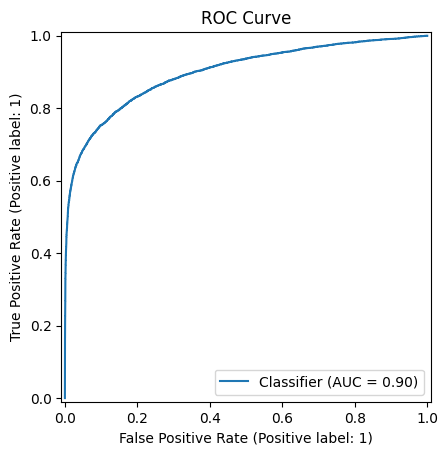

In [26]:
# ROC Curve
mh.draw_roc_curve(y_test, y_prob, "catboost_roc")

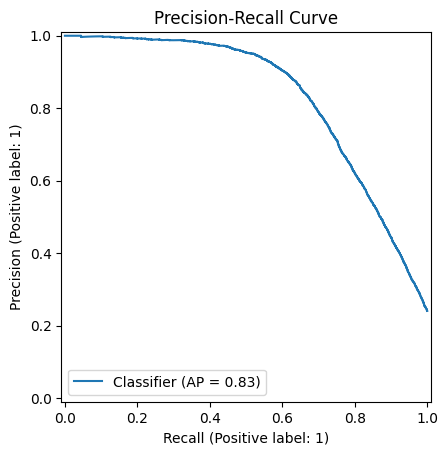

In [27]:
# PR Curve
mh.draw_pr_curve(y_test, y_prob, "catboost_pr")

In [28]:
# Persist fitted model
mh.persist_model(search, "catboost_model")

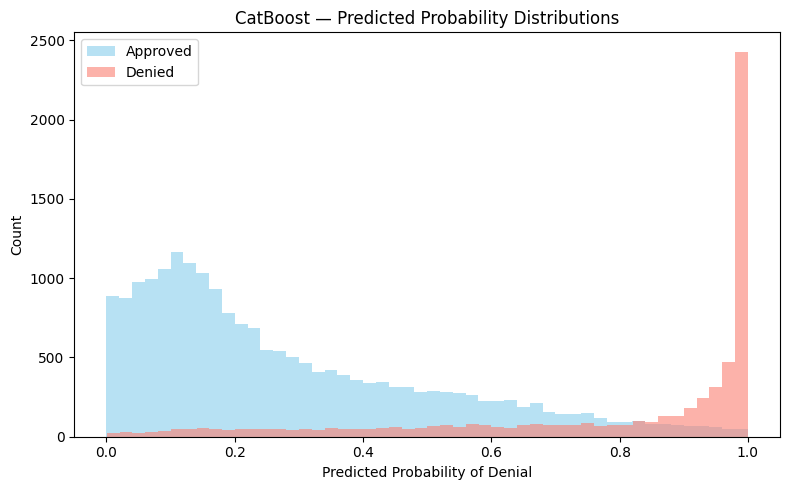

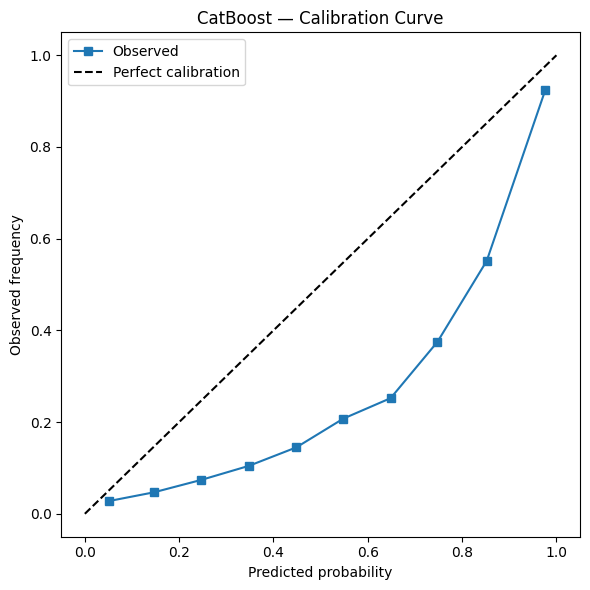

In [29]:
# Plot diagnostic charts to see how to further optimize model
mh.plot_probability_distributions(y_test, y_prob, "CatBoost")
mh.plot_calibration_curve(y_test, y_prob, "CatBoost")